In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [3]:
# Load dataset
dataset_path="/ibex/scratch/zhanl0g/projects/AraIn/modelA"
Kmeans_WGPR = pd.read_csv('/ibex/scratch/zhanl0g/projects/AraIn/labels/san_clusterred_amodel_kmeans_WGPR.csv',dtype=str)
Kmeans_WOPR = pd.read_csv('/ibex/scratch/zhanl0g/projects/AraIn/labels/san_clusterred_amodel_kmeans_WOPR.csv',dtype=str)
Kmeans_WSWP = pd.read_csv('/ibex/scratch/zhanl0g/projects/AraIn/labels/san_clusterred_amodel_kmeans_WSWP.csv',dtype=str)
Kmeans_WWCT = pd.read_csv('/ibex/scratch/zhanl0g/projects/AraIn/labels/san_clusterred_amodel_kmeans_WWCT.csv',dtype=str)

In [4]:
Kmeans=pd.DataFrame(columns=["WELL_WGPR", "WELL_WWCT", "WELL_WOPR","WELL_WSWP","class_WGPR","class_WWCT","class_WOPR","class_WSWP"])

In [5]:
Kmeans["WELL_WGPR"]= dataset_path+"/"+Kmeans_WGPR["WELL"]+"_WGPR.png"
Kmeans["WELL_WWCT"]= dataset_path+"/"+Kmeans_WOPR["WELL"]+"_WWCT.png"
Kmeans["WELL_WOPR"]= dataset_path+"/"+Kmeans_WSWP["WELL"]+"_WOPR.png"
Kmeans["WELL_WSWP"]= dataset_path+"/"+Kmeans_WWCT["WELL"]+"_WSWP.png"

Kmeans["class_WGPR"]=Kmeans_WGPR["class_"]
Kmeans["class_WOPR"]=Kmeans_WOPR["class_"]
Kmeans["class_WSWP"]=Kmeans_WSWP["class_"]
Kmeans["class_WWCT"]=Kmeans_WWCT["class_"]

In [6]:
def datagenerator(geology_property, class_):
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2)
    training_set = train_datagen.flow_from_dataframe(
        Kmeans,
        directory=None,
        x_col=geology_property,
        y_col=class_,
        weight_col=None,
        target_size=(64, 64),
        color_mode="rgba",
        classes=None,
        class_mode="categorical",
        batch_size=32,
        shuffle=True,
        seed=None,
        save_to_dir=None,
        save_prefix="",
        save_format="png",
        subset="training",
        interpolation="nearest",
        validate_filenames=True)

    test_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.2)
    validating_set = test_datagen.flow_from_dataframe(
        Kmeans,
        directory=None,
        x_col=geology_property,
        y_col=class_,
        weight_col=None,
        target_size=(64, 64),
        color_mode="rgba",
        classes=None,
        class_mode="categorical",
        batch_size=32,
        shuffle=True,
        seed=None,
        save_to_dir=None,
        save_prefix="",
        save_format="png",
        subset="validation",
        interpolation="nearest",
        validate_filenames=True)
    
    return training_set, validating_set




In [7]:
training_set_WGPR, validating_set_WGPR = datagenerator("WELL_WGPR","class_WGPR")
training_set_WWCT, validating_set_WWCT = datagenerator("WELL_WWCT", "class_WWCT")
training_set_WOPR, validating_set_WOPR = datagenerator("WELL_WOPR", "class_WWCT")
training_set_WSWP, validating_set_WSWP = datagenerator("WELL_WSWP", "class_WWCT")

Found 424 validated image filenames belonging to 5 classes.
Found 106 validated image filenames belonging to 5 classes.
Found 424 validated image filenames belonging to 6 classes.
Found 106 validated image filenames belonging to 6 classes.
Found 424 validated image filenames belonging to 6 classes.
Found 106 validated image filenames belonging to 6 classes.
Found 424 validated image filenames belonging to 6 classes.
Found 106 validated image filenames belonging to 6 classes.


In [11]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 4]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=6, activation='softmax'))
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
from tensorflow.keras.utils import plot_model
cnn.summary()
#plot_model(cnn, to_file='model.png')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        1184      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_5 (Dense)              (None, 6)                

In [12]:
def train(training_set,validating_set,property_name):
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history=cnn.fit(x = training_set, validation_data=validating_set, epochs = 100)
    
    plt.figure(1) 
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    #plt.ylim([0.5, 1])
    plt.legend(loc='best')
    #plt.show()
    plt.savefig("accuracy_%s.png" %(property_name))
    
    plt.figure(2) 
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    #plt.ylim([0.5, 1])
    plt.legend(loc='best')
    #plt.show()
    plt.savefig("loss_%s.png" %(property_name))

Epoch 1/100
14/14 [==============================] - 4s 236ms/step - loss: 0.9797 - accuracy: 0.6038 - val_loss: 1.0137 - val_accuracy: 0.6698
Epoch 2/100
14/14 [==============================] - 4s 256ms/step - loss: 0.7952 - accuracy: 0.6910 - val_loss: 0.9044 - val_accuracy: 0.6887
Epoch 3/100
14/14 [==============================] - 3s 235ms/step - loss: 0.7301 - accuracy: 0.6816 - val_loss: 0.9623 - val_accuracy: 0.6321
Epoch 4/100
14/14 [==============================] - 4s 266ms/step - loss: 0.7653 - accuracy: 0.6745 - val_loss: 0.8858 - val_accuracy: 0.6132
Epoch 5/100
14/14 [==============================] - 4s 274ms/step - loss: 0.7264 - accuracy: 0.7028 - val_loss: 1.1644 - val_accuracy: 0.6509
Epoch 6/100
14/14 [==============================] - 4s 276ms/step - loss: 0.7555 - accuracy: 0.6981 - val_loss: 0.9915 - val_accuracy: 0.5849
Epoch 7/100
14/14 [==============================] - 4s 264ms/step - loss: 0.7292 - accuracy: 0.7075 - val_loss: 0.9067 - val_accuracy: 0.6415

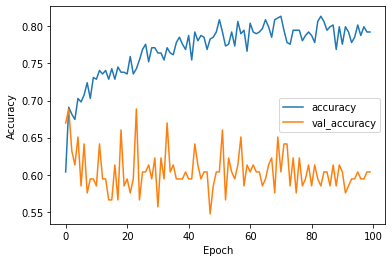

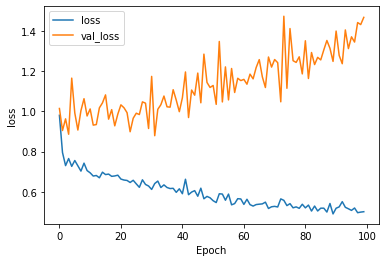

In [10]:
train(training_set_WGPR, validating_set_WGPR,"WGPR")

Epoch 1/100
14/14 [==============================] - 4s 273ms/step - loss: 1.1375 - accuracy: 0.6061 - val_loss: 0.8788 - val_accuracy: 0.7264
Epoch 2/100
14/14 [==============================] - 4s 270ms/step - loss: 0.9629 - accuracy: 0.6415 - val_loss: 0.9522 - val_accuracy: 0.6604
Epoch 3/100
14/14 [==============================] - 4s 275ms/step - loss: 0.9484 - accuracy: 0.6274 - val_loss: 0.9033 - val_accuracy: 0.7264
Epoch 4/100
14/14 [==============================] - 4s 268ms/step - loss: 0.9751 - accuracy: 0.6038 - val_loss: 0.8732 - val_accuracy: 0.7264
Epoch 5/100
14/14 [==============================] - 4s 270ms/step - loss: 0.9356 - accuracy: 0.6274 - val_loss: 0.8516 - val_accuracy: 0.7264
Epoch 6/100
14/14 [==============================] - 4s 276ms/step - loss: 0.9169 - accuracy: 0.6462 - val_loss: 0.8605 - val_accuracy: 0.7264
Epoch 7/100
14/14 [==============================] - 4s 275ms/step - loss: 0.9054 - accuracy: 0.6462 - val_loss: 0.9643 - val_accuracy: 0.5943

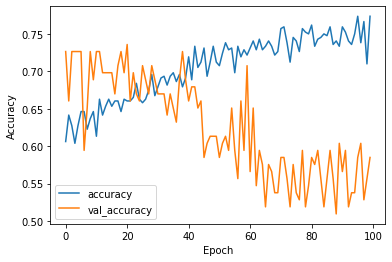

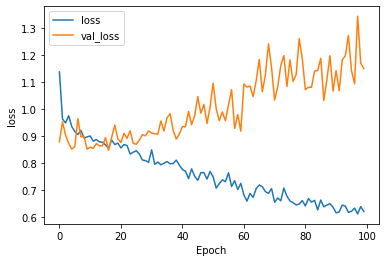

In [13]:
train(training_set_WWCT, validating_set_WWCT,"WWCT")

Epoch 1/100
14/14 [==============================] - 4s 292ms/step - loss: 1.0953 - accuracy: 0.6250 - val_loss: 0.8123 - val_accuracy: 0.7075
Epoch 2/100
14/14 [==============================] - 4s 277ms/step - loss: 0.9509 - accuracy: 0.6604 - val_loss: 0.8091 - val_accuracy: 0.6792
Epoch 3/100
14/14 [==============================] - 4s 287ms/step - loss: 0.9080 - accuracy: 0.6557 - val_loss: 0.8836 - val_accuracy: 0.7075
Epoch 4/100
14/14 [==============================] - 4s 285ms/step - loss: 0.8949 - accuracy: 0.6792 - val_loss: 0.9437 - val_accuracy: 0.6321
Epoch 5/100
14/14 [==============================] - 4s 275ms/step - loss: 0.8824 - accuracy: 0.6792 - val_loss: 0.7939 - val_accuracy: 0.6981
Epoch 6/100
14/14 [==============================] - 4s 296ms/step - loss: 0.8712 - accuracy: 0.7028 - val_loss: 0.8307 - val_accuracy: 0.6887
Epoch 7/100
14/14 [==============================] - 4s 290ms/step - loss: 0.8481 - accuracy: 0.7005 - val_loss: 0.9387 - val_accuracy: 0.6509

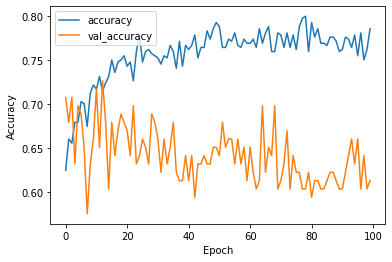

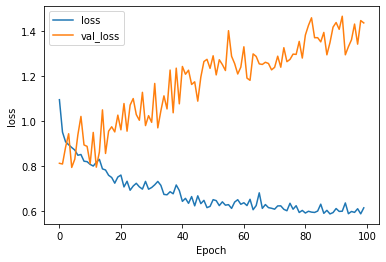

In [14]:
train(training_set_WOPR, validating_set_WOPR, "WOPR")

Epoch 1/100
14/14 [==============================] - 4s 308ms/step - loss: 1.5799 - accuracy: 0.5425 - val_loss: 1.2094 - val_accuracy: 0.7264
Epoch 2/100
14/14 [==============================] - 4s 288ms/step - loss: 1.0600 - accuracy: 0.6368 - val_loss: 0.9003 - val_accuracy: 0.7264
Epoch 3/100
14/14 [==============================] - 4s 285ms/step - loss: 1.0924 - accuracy: 0.6415 - val_loss: 0.9712 - val_accuracy: 0.7264
Epoch 4/100
14/14 [==============================] - 4s 269ms/step - loss: 1.0808 - accuracy: 0.6392 - val_loss: 0.8571 - val_accuracy: 0.7264
Epoch 5/100
14/14 [==============================] - 4s 272ms/step - loss: 1.0527 - accuracy: 0.6344 - val_loss: 0.8933 - val_accuracy: 0.7264
Epoch 6/100
14/14 [==============================] - 4s 284ms/step - loss: 1.0284 - accuracy: 0.6392 - val_loss: 0.9017 - val_accuracy: 0.7264
Epoch 7/100
14/14 [==============================] - 4s 270ms/step - loss: 1.0120 - accuracy: 0.6321 - val_loss: 0.8451 - val_accuracy: 0.7264

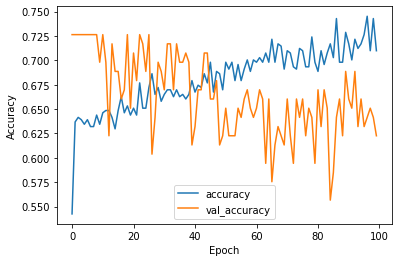

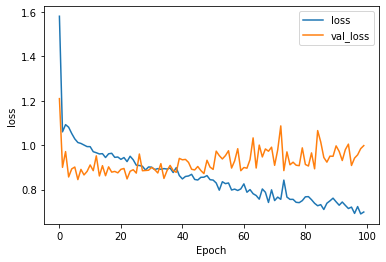

In [15]:
train(training_set_WSWP, validating_set_WSWP, "WSWP")